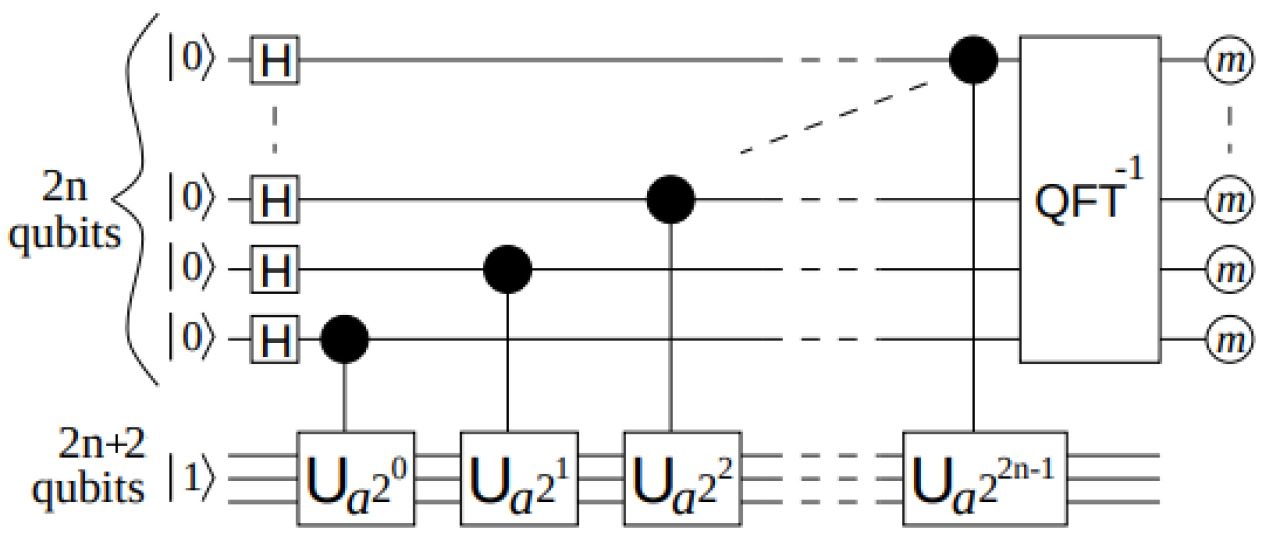

In [1]:
from qiskit import qiskit
from numpy import pi
import math
from fractions import Fraction
from random import randint
import datetime;
from qiskit.visualization import plot_histogram

In [2]:
from qiskit import qiskit
from numpy import pi

def unitary_operator_c(theta):
    return (qiskit.circuit.library.standard_gates.PhaseGate(theta,str(theta))).control(1)

def apply_unitary_operator(quantum_circuit, theta, control, target, exponent):
    quantum_circuit.append(unitary_operator_c(theta/(2**exponent)),[control, target])

def myQFT(quantum_circuit, measurement_qubits, inverse = False, swaps = False):
    if not inverse:
        index = 0
        for target in measurement_qubits:
            #quantum_circuit.barrier()
            exponent = 2
            quantum_circuit.h(target)
            for control in measurement_qubits[index + 1:]:
                apply_unitary_operator(quantum_circuit, 2 * pi, control, target, exponent)
                exponent+=1
            index+=1
        #quantum_circuit.barrier()
        if swaps:
            for x in range(0, len(measurement_qubits)//2):
                quantum_circuit.swap(measurement_qubits[x], measurement_qubits[len(measurement_qubits) - 1 - x])
                x+=1
        #quantum_circuit.barrier()
    else:
        if swaps:
            #quantum_circuit.barrier()
            for x in range(0, len(measurement_qubits)//2):
                quantum_circuit.swap(measurement_qubits[x], measurement_qubits[len(measurement_qubits) - 1 - x])
                x+=1
        index = len(measurement_qubits) -1
        for target in reversed(measurement_qubits):
            #quantum_circuit.barrier()
            exponent = len(measurement_qubits[index + 1:]) + 1
            for control in reversed(measurement_qubits[index + 1:]):
                apply_unitary_operator(quantum_circuit, -2 * pi, control, target, exponent)
                exponent -= 1
            quantum_circuit.h(target)
            index-=1
        #quantum_circuit.barrier()

In [3]:
def binToDez(bin: list[int]) -> int:
    dez = 0
    index = 0
    for e in range(len(bin)):
        dez += (2**e)* bin[index]
        index+=1
    return dez

def dezToBin(dez: int, length: int = -1) -> list[int]:
    bin = list(reversed([int(i) for i in list('{0:0b}'.format(dez))]))
    if length != -1:
        while len(bin) < length:
            bin = bin + [0]
    return bin

    
def modular_exponentiation(base : int , exponent : int, modulus : int) -> int:
    """
    returns base**exponent % modulus 
    """
    result = 1
    base = base % modulus
    while exponent > 0:
        if exponent % 2 == 1:
            result = (result * base) % modulus
        exponent = exponent >> 1
        base = (base * base) % modulus
    return result   

In [4]:
from egcd import egcd
def gcd(a : int, N : int) -> int:
    """
    returns the inverse element of a in modulo N
    """
    g, a_inv, _ = egcd(a,N)
    if g != 1:
        raise Exception('modular inverse does not exist') 
    else:
        if a_inv < 0:
            a_inv = a_inv % N
        return a_inv

In [5]:
def P_Gate(theta: float, controls: int = 0) -> qiskit.circuit.library.standard_gates.PhaseGate:
    if controls > 0:
        return (qiskit.circuit.library.standard_gates.PhaseGate(theta,str(theta))).control(controls)
    else:
        return (qiskit.circuit.library.standard_gates.PhaseGate(theta,str(theta)))
    
""" Возвращает вентиль фазы с количеством управляемых входов, равным *controls*.
Вентиль фазы для одного кубита выглядит следующим образом:
( 1        0     )
( 0  e^(i*theta) )

Параметры:
theta: float
    определяет сдвиг фазы
controls: int
    задает количество управляющих кубитов. По умолчанию = 0

Возвращает: Вентиль фазы с количеством управляемых входов, равным *controls* """

' Возвращает вентиль фазы с количеством управляемых входов, равным *controls*.\nВентиль фазы для одного кубита выглядит следующим образом:\n( 1        0     )\n( 0  e^(i*theta) )\n\nПараметры:\ntheta: float\n    определяет сдвиг фазы\ncontrols: int\n    задает количество управляющих кубитов. По умолчанию = 0\n\nВозвращает: Вентиль фазы с количеством управляемых входов, равным *controls* '

In [6]:
def A_Gate(a_bin: list[int]) -> qiskit.circuit.gate:
    A_Gate = qiskit.QuantumCircuit(len(a_bin))
    theta_list = [0.0]*len(a_bin)
    for target_bit in range(len(a_bin)):
        exponent = 1
        for control_bit in reversed(range(target_bit+1)):
            if a_bin[control_bit] == 1:
                theta_list[target_bit]+= 2*pi/(2**(exponent))
            exponent+=1
    for qubit_index in range(len(a_bin)):
        A_Gate.append(P_Gate(theta_list[qubit_index]),[qubit_index])
    A_Gate = A_Gate.to_gate()
    A_Gate.name = "Add " + str (binToDez(a_bin))
    return A_Gate

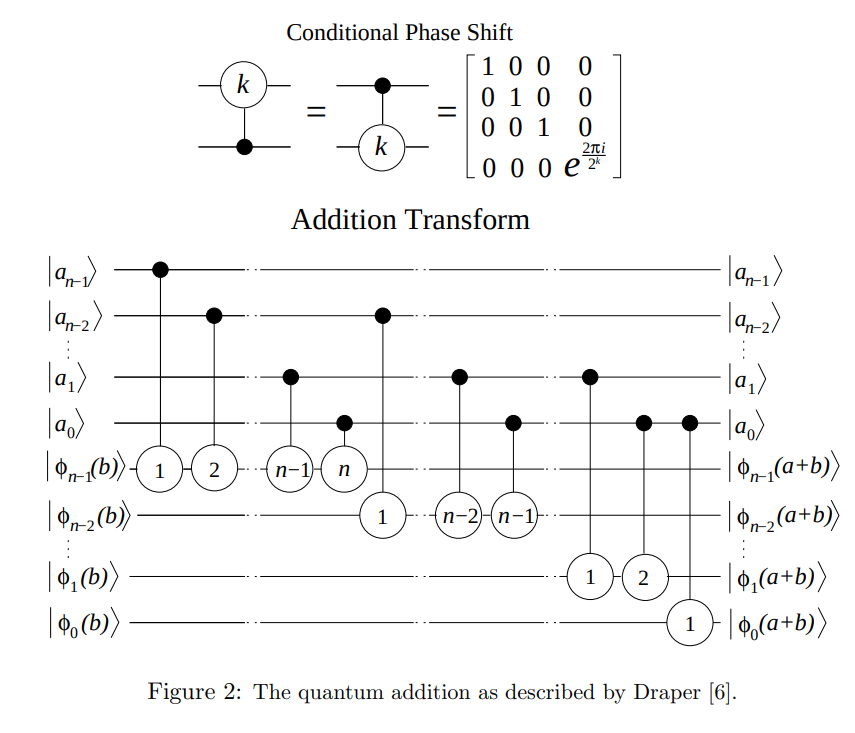

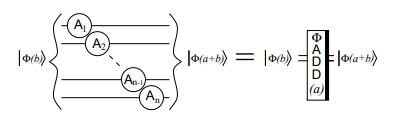

In [7]:
qc = qiskit.QuantumCircuit(5,5)
qc.x(0)
qc.x(1)
qc.x(3) #  b = 1 + 8 = 9 + 2 = 11
qc.barrier()
mes = [4,3,2,1,0]
myQFT(qc,mes) # b transform into fourier base 
qc.append(A_Gate([1,1,1,1,0]),[0,1,2,3,4]) # first list defines a, here: [1,1,1,1,0] = 1 + 2 + 4 + 8 = 15
myQFT(qc,mes,inverse = True)  # b back to "classical" base 
qc.barrier()
qc.measure(range(5),range(5)) # Messurment will be in usually bit order - MSB first.
qc.draw()


┌───┐ ░                                                                  »
q_0: ┤ X ├─░────────────────────────────────────────────────■─────────────────»
     ├───┤ ░                                                │                 »
q_1: ┤ X ├─░──────────────────────────────■─────────────────┼─────────■───────»
     └───┘ ░                              │                 │         │       »
q_2: ──────░────────────────■─────────────┼────────■────────┼─────────┼───────»
     ┌───┐ ░                │       ┌───┐ │        │P(π/2)  │         │P(π/4) »
q_3: ┤ X ├─░───────■────────┼───────┤ H ├─┼────────■────────┼─────────■───────»
     └───┘ ░ ┌───┐ │P(π/2)  │P(π/4) └───┘ │P(π/8)           │P(π/16)          »
q_4: ──────░─┤ H ├─■────────■─────────────■─────────────────■─────────────────»
           ░ └───┘                                                            »
c: 5/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                                   ┌───┐┌─────────┐┌───┐»
«q_0: ──────■─────────────────■─────────────■───────┤ H ├┤0        ├┤ H ├»
«           │                 │       ┌───┐ │P(π/2) └───┘│         │└───┘»
«q_1: ──────┼────────■────────┼───────┤ H ├─■────────────┤1        ├─────»
«     ┌───┐ │        │P(π/2)  │P(π/4) └───┘              │         │     »
«q_2: ┤ H ├─┼────────■────────■──────────────────────────┤2 Add 15 ├─────»
«     └───┘ │P(π/8)                                      │         │     »
«q_3: ──────■────────────────────────────────────────────┤3        ├─────»
«                                                        │         │     »
«q_4: ───────────────────────────────────────────────────┤4        ├─────»
«                                                        └─────────┘     »
«c: 5/═══════════════════════════════════════════════════════════════════»
«                                                                        »
«                                                                            »
«q_0: ─■──────────────■───────────────────■────────────────────────■─────────»
«      │P(-π/2) ┌───┐ │                   │                        │         »
«q_1: ─■────────┤ H ├─┼─────────■─────────┼──────────────■─────────┼─────────»
«               └───┘ │P(-π/4)  │P(-π/2)  │        ┌───┐ │         │         »
«q_2: ────────────────■─────────■─────────┼────────┤ H ├─┼─────────┼─────────»
«                                         │P(-π/8) └───┘ │P(-π/4)  │         »
«q_3: ────────────────────────────────────■──────────────■─────────┼─────────»
«                                                                  │P(-π/16) »
«q_4: ─────────────────────────────────────────────────────────────■─────────»
«                                                                            »
«c: 5/═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«                                                        ░ ┌─┐            
«q_0: ───────────────────────────────────────────────────░─┤M├────────────
«                                                        ░ └╥┘┌─┐         
«q_1: ───────────■───────────────────────────────────────░──╫─┤M├─────────
«                │                                       ░  ║ └╥┘┌─┐      
«q_2: ─■─────────┼──────────────■────────────────────────░──╫──╫─┤M├──────
«      │P(-π/2)  │        ┌───┐ │                        ░  ║  ║ └╥┘┌─┐   
«q_3: ─■─────────┼────────┤ H ├─┼─────────■──────────────░──╫──╫──╫─┤M├───
«                │P(-π/8) └───┘ │P(-π/4)  │P(-π/2) ┌───┐ ░  ║  ║  ║ └╥┘┌─┐
«q_4: ───────────■──────────────■─────────■────────┤ H ├─░──╫──╫──╫──╫─┤M├
«                                                  └───┘ ░  ║  ║  ║  ║ └╥┘
«c: 5/══════════════════════════════════════════════════════╩══╩══╩══╩══╩═
«                                                           0  

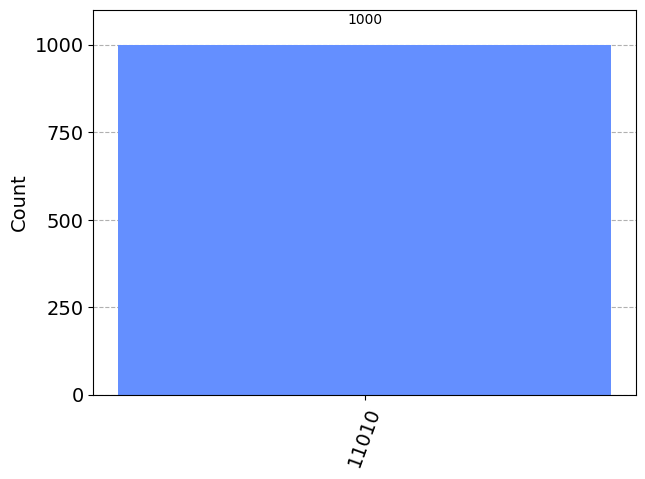

In [8]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)

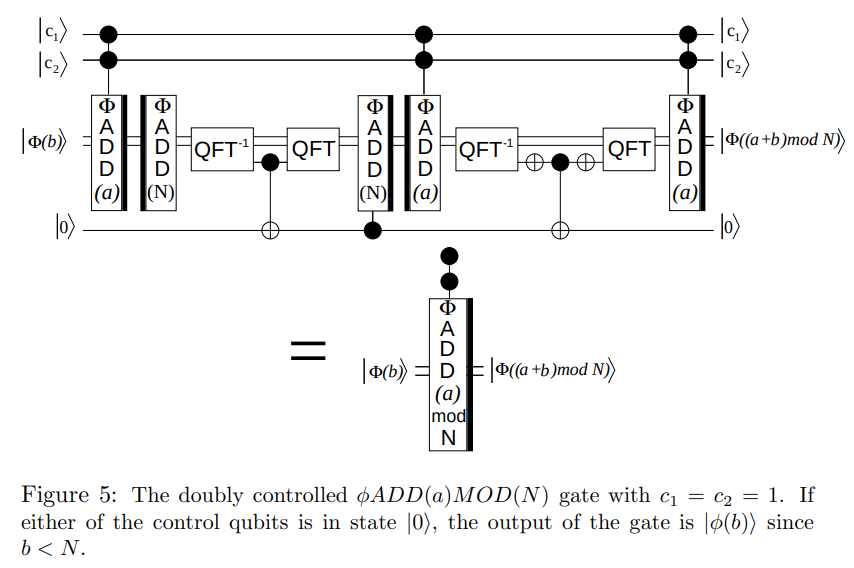

In [9]:
def modular_adder_gate(a_bin: list[int],N_bin: list[int]) -> qiskit.circuit.gate:
    
    modular_adder_gate = qiskit.QuantumCircuit(2 + len(a_bin) + 1) # 2 Control Qubits + qubits for the input + ancillary qubit
    modular_adder_gate.append(A_Gate(a_bin).control(2), [0,1] + list(range(2, len(a_bin)+2)))
    modular_adder_gate.append(A_Gate(N_bin).inverse(), list(range(2, len(a_bin)+2)))
    myQFT(modular_adder_gate,list(reversed(range(2, len(a_bin)+2))),inverse = True)
    modular_adder_gate.cnot(len(a_bin)+1,len(a_bin)+2)
    myQFT(modular_adder_gate,list(reversed(range(2, len(a_bin)+2))))
    modular_adder_gate.append(A_Gate(N_bin).control(1), [len(a_bin)+2] + list(range(2, len(a_bin)+2)))
    modular_adder_gate.append(A_Gate(a_bin).inverse().control(2), [0,1] + list(range(2, len(a_bin)+2)))
    myQFT(modular_adder_gate,list(reversed(range(2, len(a_bin)+2))),inverse = True)
    modular_adder_gate.x(len(a_bin)+1)
    modular_adder_gate.cnot(len(a_bin)+1,len(a_bin)+2)
    modular_adder_gate.x(len(a_bin)+1)
    myQFT(modular_adder_gate,list(reversed(range(2, len(a_bin)+2))))
    modular_adder_gate.append(A_Gate(a_bin).control(2), [0,1] + list(range(2, len(a_bin)+2)))
    modular_adder_gate = modular_adder_gate.to_gate()
    modular_adder_gate.name = "Add " + str(binToDez(a_bin)) + " Mod " + str(binToDez(N_bin))
    return modular_adder_gate

"""
    Возвращает вентиль модульного сумматора. Вентиль требует 2 + len(a_bin) + 1 кубит. Первые два кубита являются контрольными, 
    последний - вспомогательный кубит, который должен быть в состоянии |0> в начале.

    Параметры:
    a_bin: list[int]
        Двоичное представление классического слагаемого a. Первый элемент списка должен быть наименее значащим битом, 
        а последний элемент - наиболее значащим битом. Например, [0,0,0,1] представляет десятичное число 8.
    N_bin: list[int]
        Двоичное представление модуля N / простого множителя. Первый элемент списка должен быть наименее значащим битом, 
        а последний элемент - наиболее значащим битом. Например, [0,0,0,1] представляет десятичное число 8.

    Возвращает: вентиль модульного сумматора
    """

'\n    Возвращает вентиль модульного сумматора. Вентиль требует 2 + len(a_bin) + 1 кубит. Первые два кубита являются контрольными, \n    последний - вспомогательный кубит, который должен быть в состоянии |0> в начале.\n\n    Параметры:\n    a_bin: list[int]\n        Двоичное представление классического слагаемого a. Первый элемент списка должен быть наименее значащим битом, \n        а последний элемент - наиболее значащим битом. Например, [0,0,0,1] представляет десятичное число 8.\n    N_bin: list[int]\n        Двоичное представление модуля N / простого множителя. Первый элемент списка должен быть наименее значащим битом, \n        а последний элемент - наиболее значащим битом. Например, [0,0,0,1] представляет десятичное число 8.\n\n    Возвращает: вентиль модульного сумматора\n    '

In [10]:
qc = qiskit.QuantumCircuit(8,6)
#контролируемые
qc.x(1)
qc.x(0)
#+ q7 - вспомогательный
#наше исходное число:
qc.x(3)
qc.x(4)
qc.x(5)
# b = [01110] = 2+4+8=14
qc.barrier()
mes = [6,5,4,3,2]
myQFT(qc,mes)               #[a = 13]    [N = 15]
qc.append(modular_adder_gate([1,0,1,1,0],[1,1,1,1,0]),[0,1,2,3,4,5,6,7])
myQFT(qc,mes,inverse = True)
qc.barrier()
qc.measure(range(2,8),range(6))
qc.draw()

┌───┐ ░                                                                  »
q_0: ┤ X ├─░──────────────────────────────────────────────────────────────────»
     ├───┤ ░                                                                  »
q_1: ┤ X ├─░──────────────────────────────────────────────────────────────────»
     └───┘ ░                                                                  »
q_2: ──────░────────────────────────────────────────────────■─────────────────»
     ┌───┐ ░                                                │                 »
q_3: ┤ X ├─░──────────────────────────────■─────────────────┼─────────■───────»
     ├───┤ ░                              │                 │         │       »
q_4: ┤ X ├─░────────────────■─────────────┼────────■────────┼─────────┼───────»
     ├───┤ ░                │       ┌───┐ │        │P(π/2)  │         │P(π/4) »
q_5: ┤ X ├─░───────■────────┼───────┤ H ├─┼────────■────────┼─────────■───────»
     └───┘ ░ ┌───┐ │P(π/2)  │P(π/4) └───┘ │P(π/8)           │P(π/16)          »
q_6: ──────░─┤ H ├─■────────■─────────────■─────────────────■─────────────────»
           ░ └───┘                                                            »
q_7: ──────░──────────────────────────────────────────────────────────────────»
           ░                                                                  »
c: 6/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                                        ┌────────────────┐»
«q_0: ───────────────────────────────────────────────────┤0               ├»
«                                                        │                │»
«q_1: ───────────────────────────────────────────────────┤1               ├»
«                                                   ┌───┐│                │»
«q_2: ──────■─────────────────■─────────────■───────┤ H ├┤2               ├»
«           │                 │       ┌───┐ │P(π/2) └───┘│                │»
«q_3: ──────┼────────■────────┼───────┤ H ├─■────────────┤3               ├»
«     ┌───┐ │        │P(π/2)  │P(π/4) └───┘              │  Add 13 Mod 15 │»
«q_4: ┤ H ├─┼────────■────────■──────────────────────────┤4               ├»
«     └───┘ │P(π/8)                                      │                │»
«q_5: ──────■────────────────────────────────────────────┤5               ├»
«                                                        │                │»
«q_6: ───────────────────────────────────────────────────┤6               ├»
«                                                        │                │»
«q_7: ───────────────────────────────────────────────────┤7               ├»
«                                                        └────────────────┘»
«c: 6/═════════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                                      »
«q_0: ─────────────────────────────────────────────────────────────────»
«                                                                      »
«q_1: ─────────────────────────────────────────────────────────────────»
«     ┌───┐                                                            »
«q_2: ┤ H ├─■──────────────■───────────────────■───────────────────────»
«     └───┘ │P(-π/2) ┌───┐ │                   │                       »
«q_3: ──────■────────┤ H ├─┼─────────■─────────┼──────────────■────────»
«                    └───┘ │P(-π/4)  │P(-π/2)  │        ┌───┐ │        »
«q_4: ─────────────────────■─────────■─────────┼────────┤ H ├─┼────────»
«                                              │P(-π/8) └───┘ │P(-π/4) »
«q_5: ─────────────────────────────────────────■──────────────■────────»
«                                                                      »
«q_6: ─────────────────────────────────────────────────────────────────»


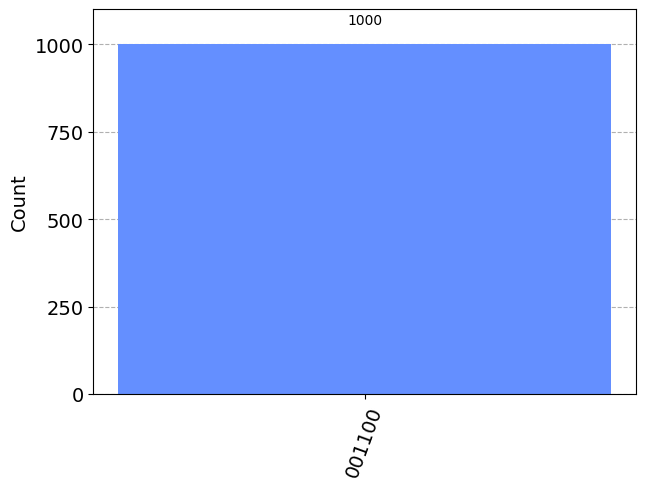

In [11]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)

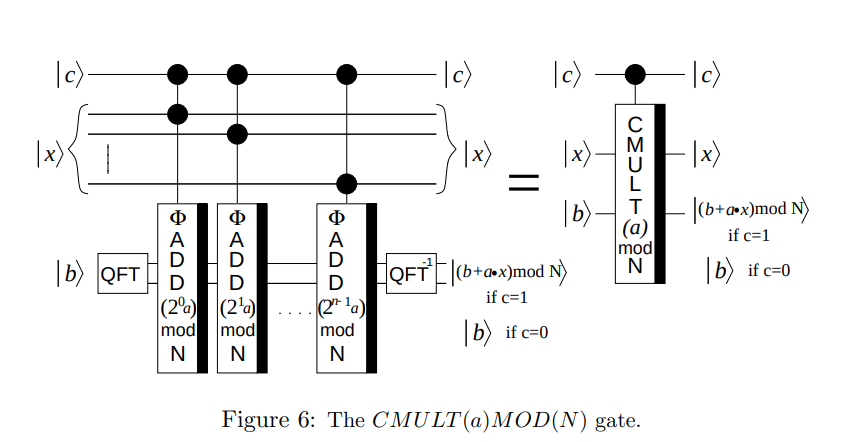

In [12]:
def cmult_gate(x_bits_amount: int,a_bin: list[int],N_bin: list[int]) -> qiskit.circuit.gate:
    a_dez = binToDez(a_bin)
    N_dez = binToDez(N_bin)
    cmult_gate = qiskit.QuantumCircuit(1 + x_bits_amount + len(a_bin) + 1)
    myQFT(cmult_gate,list(reversed(range(1+x_bits_amount, 1 + x_bits_amount + len(a_bin)))))
    for i in range(1, len(a_bin)):
        a_i = ((2**(i - 1)) *  a_dez) % N_dez
        a_i_bin = dezToBin(a_i, len(a_bin))
        cmult_gate.append(modular_adder_gate(a_i_bin, N_bin), [0,i] + list(range(1+x_bits_amount, 1 + x_bits_amount + len(a_bin) + 1)))
    myQFT(cmult_gate,list(reversed(range(1+x_bits_amount, 1 + x_bits_amount + len(a_bin)))),inverse = True)
    cmult_gate = cmult_gate.to_gate()
    cmult_gate.name = "cmult " + str(a_dez) + " Mod " + str(N_dez)
    return cmult_gate

""""
Возвращает вентиль контролируемого умножителя.
Вентиль требует 1 + x_bits_amount + len(a_bit) + 1 кубитов.
Первый кубит является контрольным. Следующие x_bits_amount кубитов предназначены для кубитов числа x. a_bit должен иметь ту же длину, что и входные кубиты b. 
Последний кубит является вспомогательным для базовых вентилей modular_adder_gates.

Параметры:
x_bits_amount: int
   количество кубитов для x в виде целого числа.
a_bin: list[int]
   a_bin для вычисления вентиля. a_bin должен иметь ту же длину, что и N_bin, и столько же двоичных битов, сколько кубитов b.
N_bin: list[int]
   N_bin для вычисления вентиля. N_bin должен иметь ту же длину, что и a_bin.

Возвращает: вентиль контролируемого умножителя
"""

'"\nВозвращает вентиль контролируемого умножителя.\nВентиль требует 1 + x_bits_amount + len(a_bit) + 1 кубитов.\nПервый кубит является контрольным. Следующие x_bits_amount кубитов предназначены для кубитов числа x. a_bit должен иметь ту же длину, что и входные кубиты b. \nПоследний кубит является вспомогательным для базовых вентилей modular_adder_gates.\n\nПараметры:\nx_bits_amount: int\n   количество кубитов для x в виде целого числа.\na_bin: list[int]\n   a_bin для вычисления вентиля. a_bin должен иметь ту же длину, что и N_bin, и столько же двоичных битов, сколько кубитов b.\nN_bin: list[int]\n   N_bin для вычисления вентиля. N_bin должен иметь ту же длину, что и a_bin.\n\nВозвращает: вентиль контролируемого умножителя\n'

In [13]:
qc = qiskit.QuantumCircuit(11,10)
#qc.x(0)    # ==c
#X_bits
qc.x(1)
qc.x(2)
qc.x(3)
qc.x(4)
#5-6 control
qc.x(5)
qc.x(6)
#b = [011] = 
qc.x(7)
qc.x(8)         # x=[15]*a=[1+2+4]modN=[1+2+4+8]
qc.append(cmult_gate(4,[1,1,1,0,0],[1,1,1,1,0]),range(11))
#6 + 4*7   mod 15 == 28+6 mod 15 = 4 
qc.measure(range(1,11),range(10))
qc.draw()

┌──────────────────┐                              
 q_0: ─────┤0                 ├──────────────────────────────
      ┌───┐│                  │┌─┐                           
 q_1: ┤ X ├┤1                 ├┤M├───────────────────────────
      ├───┤│                  │└╥┘┌─┐                        
 q_2: ┤ X ├┤2                 ├─╫─┤M├────────────────────────
      ├───┤│                  │ ║ └╥┘┌─┐                     
 q_3: ┤ X ├┤3                 ├─╫──╫─┤M├─────────────────────
      ├───┤│                  │ ║  ║ └╥┘┌─┐                  
 q_4: ┤ X ├┤4                 ├─╫──╫──╫─┤M├──────────────────
      ├───┤│                  │ ║  ║  ║ └╥┘┌─┐               
 q_5: ┤ X ├┤5  cmult 7 Mod 15 ├─╫──╫──╫──╫─┤M├───────────────
      ├───┤│                  │ ║  ║  ║  ║ └╥┘┌─┐            
 q_6: ┤ X ├┤6                 ├─╫──╫──╫──╫──╫─┤M├────────────
      ├───┤│                  │ ║  ║  ║  ║  ║ └╥┘┌─┐         
 q_7: ┤ X ├┤7                 ├─╫──╫──╫──╫──╫──╫─┤M├─────────
      ├───┤│                  │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
 q_8: ┤ X ├┤8                 ├─╫──╫──╫──╫──╫──╫──╫─┤M├──────
      └───┘│                  │ ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_9: ─────┤9                 ├─╫──╫──╫──╫──╫──╫──╫──╫─┤M├───
           │                  │ ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_10: ─────┤10                ├─╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
           └──────────────────┘ ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
c: 10/══════════════════════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
                                0  1  2  3  4  5  6  7  8  9

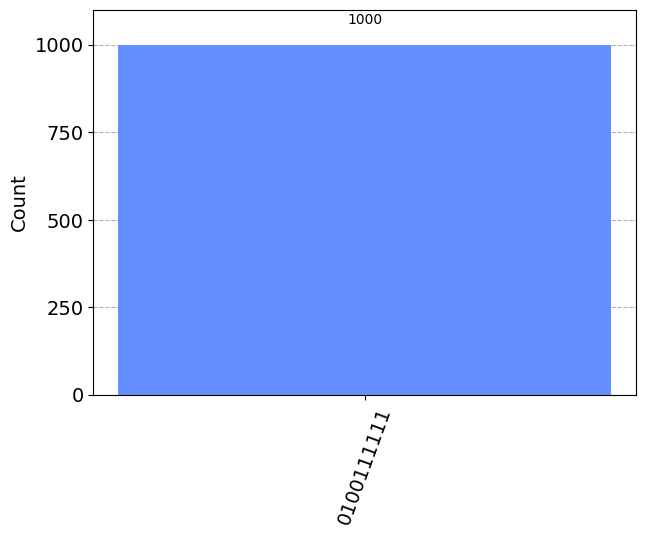

In [14]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)

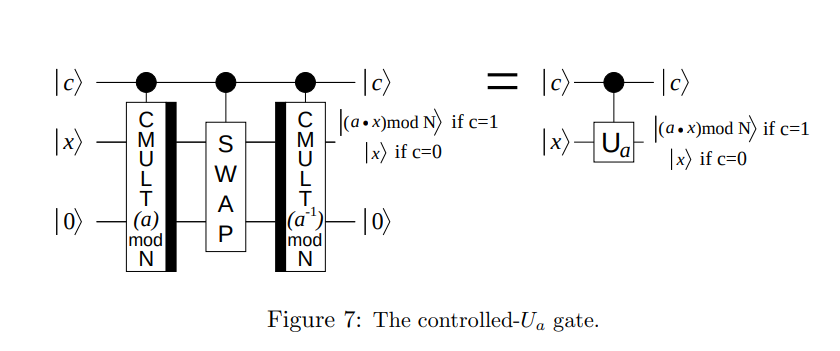

In [15]:
def U_a_gate(x_bits_amount: int,a_bin: list[int],N_bin: list[int]) -> qiskit.circuit.gate:
    U_a_gate = qiskit.QuantumCircuit(1 + x_bits_amount + len(a_bin) + 1)
    U_a_gate.append(cmult_gate(x_bits_amount,a_bin ,N_bin), range(1 + x_bits_amount + len(a_bin) + 1))
    for i in (range(1,x_bits_amount + 1)):
        U_a_gate.cswap(0,i,i+x_bits_amount)
    a_inv_bin = dezToBin(gcd(binToDez(a_bin),binToDez(N_bin)),len(a_bin))
    U_a_gate.append(cmult_gate(x_bits_amount,a_inv_bin ,N_bin).inverse(), range(1 + x_bits_amount + len(a_bin) + 1))
    U_a_gate = U_a_gate.to_gate()
    U_a_gate.name = "U_" + str(binToDez(a_bin))
    return U_a_gate

In [16]:
qc = qiskit.QuantumCircuit(11,10)
qc.x(0) #control C
# x = [110100000] = 1+2+8=11
qc.x(1)
qc.x(2)
qc.x(4)         #    a[13]        N[15]
qc.append(U_a_gate(4,[1,0,1,1,0],[1,1,1,1,0]),range(11))
qc.measure(range(1,11),range(10))
# ПОЛУЧАЕМ x*a mod N == 8 
qc.draw()
# a должно быть взаимно простое с N

┌───┐┌────────┐                              
 q_0: ┤ X ├┤0       ├──────────────────────────────
      ├───┤│        │┌─┐                           
 q_1: ┤ X ├┤1       ├┤M├───────────────────────────
      ├───┤│        │└╥┘┌─┐                        
 q_2: ┤ X ├┤2       ├─╫─┤M├────────────────────────
      └───┘│        │ ║ └╥┘┌─┐                     
 q_3: ─────┤3       ├─╫──╫─┤M├─────────────────────
      ┌───┐│        │ ║  ║ └╥┘┌─┐                  
 q_4: ┤ X ├┤4       ├─╫──╫──╫─┤M├──────────────────
      └───┘│        │ ║  ║  ║ └╥┘┌─┐               
 q_5: ─────┤5  U_13 ├─╫──╫──╫──╫─┤M├───────────────
           │        │ ║  ║  ║  ║ └╥┘┌─┐            
 q_6: ─────┤6       ├─╫──╫──╫──╫──╫─┤M├────────────
           │        │ ║  ║  ║  ║  ║ └╥┘┌─┐         
 q_7: ─────┤7       ├─╫──╫──╫──╫──╫──╫─┤M├─────────
           │        │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
 q_8: ─────┤8       ├─╫──╫──╫──╫──╫──╫──╫─┤M├──────
           │        │ ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_9: ─────┤9       ├─╫──╫──╫──╫──╫──╫──╫──╫─┤M├───
           │        │ ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_10: ─────┤10      ├─╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
           └────────┘ ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
c: 10/════════════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
                      0  1  2  3  4  5  6  7  8  9

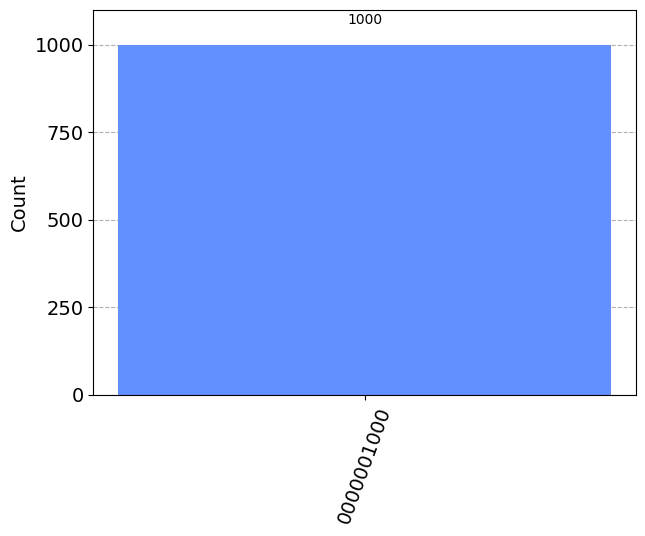

In [17]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=1000).result().get_counts(qc)
plot_histogram(counts)


Классическая часть


In [18]:
from fractions import Fraction
from math import gcd as gcd_math

def bitstring_to_int(bitstring):
    """Convert a bitstring to an integer."""
    return int(bitstring, 2)

def continued_fraction_convergents(x):
    """Generate the convergents of a continued fraction."""
    fractions = []
    while x.denominator != 1:
        fractions.append(x)
        x = 1 / (x - int(x))
        x = x.limit_denominator()
    return fractions

def classical_shor(N, a, counts):
    """
    Реализует классическую часть алгоритма Шора на основе результатов квантовой части.

    Parameters:
        N (int): Число, подлежащее факторизации.
        a (int): Основа.
        counts (dict): Полученные измерения квантовой части в виде гистограммы (битовые строки).

    Returns:
        factors (tuple or None): Пара множителей числа N или None, если факторизация не удалась.
    """
    # Преобразуем ключи гистограммы в целые числа
    counts_int = {bitstring_to_int(key): value for key, value in counts.items()}

    # Получение значений с наибольшей частотой
    ordered_counts = sorted(counts_int.items(), key=lambda item: item[1], reverse=True)

    s_values = [k for k, _ in ordered_counts if k != 0]
    n = max(s_values).bit_length()
    M = 2 ** n

    # Найдем r используя аппроксимации непрерывными дробями
    for s in s_values:
        frac = Fraction(s, M).limit_denominator(N)
        convergents = continued_fraction_convergents(frac)
        for convergent in convergents:
            r = convergent.denominator
            if pow(a, r, N) == 1:
                print(f"Найденный порядок: {r}")
                if r % 2 != 0:
                    continue
                try:
                    factor1 = gcd_math(pow(a, r // 2, N) - 1, N)
                    factor2 = gcd_math(pow(a, r // 2, N) + 1, N)
                    if factor1 != 1 and factor2 != 1 and factor1 * factor2 == N:
                        print(f"Множители числа {N} (а = {a}): {factor1} * {factor2}")
                        return factor1, factor2
                except Exception as e:
                    print(f"Ошибка при нахождении множителей: {e}")

    print(f"Не удалось найти множители для числа {N} с основой {a} на основе предоставленных данных.")
    return None  # Если факторизация не удалась

ИТОГОВАЯ СХЕМА, ПОИСК ПЕРИОДА

N=15

In [20]:
a = 2
N = 15
n = 4
N_COUNT = n*2
qc = qiskit.QuantumCircuit(4*n+2,N_COUNT) # 4*n+2 size for complete input bits, 2*n (N_COUNT) size of the control qubits which will also be measured
for h in range(N_COUNT):
    qc.h(h)
qc.x(N_COUNT)
for control in range(N_COUNT):
    qc.append(U_a_gate(n,dezToBin(modular_exponentiation(a, 2**control, N),n+1),dezToBin(N,n+1)),[control] + list(range(N_COUNT,4*n+2)))
myQFT(qc,list(reversed(range(0,N_COUNT))),inverse = True,swaps = True)
qc.measure(range(N_COUNT),range(N_COUNT))
qc.draw()

┌───┐┌───────┐                                                      »
 q_0: ┤ H ├┤0      ├──────────────────────────────────────────────────────»
      ├───┤│       │┌───────┐                                             »
 q_1: ┤ H ├┤       ├┤0      ├─────────────────────────────────────────────»
      ├───┤│       ││       │┌───────┐                                    »
 q_2: ┤ H ├┤       ├┤       ├┤0      ├───────────────────────────────X────»
      ├───┤│       ││       ││       │┌───────┐                      │    »
 q_3: ┤ H ├┤       ├┤       ├┤       ├┤0      ├─────────────X────────┼────»
      ├───┤│       ││       ││       ││       │┌───────┐    │        │    »
 q_4: ┤ H ├┤       ├┤       ├┤       ├┤       ├┤0      ├────X────────┼────»
      ├───┤│       ││       ││       ││       ││       │┌───────┐    │    »
 q_5: ┤ H ├┤       ├┤       ├┤       ├┤       ├┤       ├┤0      ├────X────»
      ├───┤│       ││       ││       ││       ││       ││       │┌───────┐»
 q_6: ┤ H ├┤       ├┤       ├┤       ├┤       ├┤       ├┤       ├┤0      ├»
      ├───┤│       ││       ││       ││       ││       ││       ││       │»
 q_7: ┤ H ├┤       ├┤       ├┤       ├┤       ├┤       ├┤       ├┤       ├»
      ├───┤│       ││       ││       ││       ││       ││       ││       │»
 q_8: ┤ X ├┤1      ├┤1      ├┤1      ├┤1      ├┤1      ├┤1      ├┤1      ├»
      └───┘│   U_2 ││       ││       ││       ││       ││       ││       │»
 q_9: ─────┤2      ├┤2  U_4 ├┤2      ├┤2      ├┤2      ├┤2      ├┤2      ├»
           │       ││       ││   U_1 ││       ││       ││       ││       │»
q_10: ─────┤3      ├┤3      ├┤3      ├┤3  U_1 ├┤3      ├┤3      ├┤3      ├»
           │       ││       ││       ││       ││   U_1 ││       ││       │»
q_11: ─────┤4      ├┤4      ├┤4      ├┤4      ├┤4      ├┤4  U_1 ├┤4      ├»
           │       ││       ││       ││       ││       ││       ││   U_1 │»
q_12: ─────┤5      ├┤5      ├┤5      ├┤5      ├┤5      ├┤5      ├┤5      ├»
           │       ││       ││       ││       ││       ││       ││       │»
q_13: ─────┤6      ├┤6      ├┤6      ├┤6      ├┤6      ├┤6      ├┤6      ├»
           │       ││       ││       ││       ││       ││       ││       │»
q_14: ─────┤7      ├┤7      ├┤7      ├┤7      ├┤7      ├┤7      ├┤7      ├»
           │       ││       ││       ││       ││       ││       ││       │»
q_15: ─────┤8      ├┤8      ├┤8      ├┤8      ├┤8      ├┤8      ├┤8      ├»
           │       ││       ││       ││       ││       ││       ││       │»
q_16: ─────┤9      ├┤9      ├┤9      ├┤9      ├┤9      ├┤9      ├┤9      ├»
           │       ││       ││       ││       ││       ││       ││       │»
q_17: ─────┤10     ├┤10     ├┤10     ├┤10     ├┤10     ├┤10     ├┤10     ├»
           └───────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘»
 c: 8/════════════════════════════════════════════════════════════════════»
                                                                          »
«                  ┌───┐                                                  »
« q_0: ──────────X─┤ H ├─■──────────────■───────────────────■─────────────»
«                │ └───┘ │P(-π/2) ┌───┐ │                   │             »
« q_1: ────X─────┼───────■────────┤ H ├─┼─────────■─────────┼─────────────»
«          │     │                └───┘ │P(-π/4)  │P(-π/2)  │        ┌───┐»
« q_2: ────┼─────┼──────────────────────■─────────■─────────┼────────┤ H ├»
«          │     │                                          │P(-π/8) └───┘»
« q_3: ────┼─────┼──────────────────────────────────────────■─────────────»
«          │     │                                                        »
« q_4: ────┼─────┼────────────────────────────────────────────────────────»
«          │     │                                                        »
« q_5: ────┼─────┼────────────────────────────────────────────────────────»
«          │     │                                                        »
« q_6: ────X─────┼────────────────────────────────────

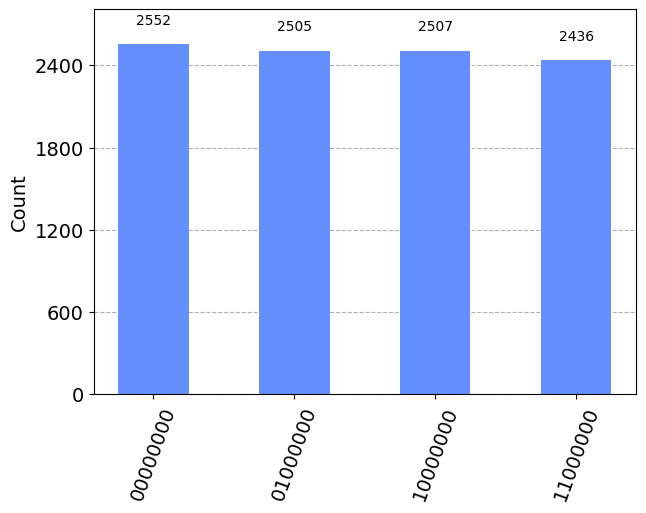

In [97]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=10000).result().get_counts(qc)
plot_histogram(counts)

In [98]:
classical_shor(N, a, counts)

Найденный порядок: 4
Множители числа 15 (а = 2): 3 * 5


(3, 5)

N=21

In [99]:
a = 13
N = 21
n = 5
N_COUNT = n*2
qc = qiskit.QuantumCircuit(4*n+2,N_COUNT) # 4*n+2 size for complete input bits, 2*n (N_COUNT) size of the control qubits which will also be measured
for h in range(N_COUNT):
    qc.h(h)
qc.x(N_COUNT)
for control in range(N_COUNT):
    qc.append(U_a_gate(n,dezToBin(modular_exponentiation(a, 2**control, N),n+1),dezToBin(N,n+1)),[control] + list(range(N_COUNT,4*n+2)))
qc.barrier()
myQFT(qc,list(reversed(range(0,N_COUNT))),inverse = True,swaps = True)
qc.barrier()
qc.measure(range(N_COUNT),range(N_COUNT))
qc.draw()

┌───┐┌────────┐                                                      »
 q_0: ┤ H ├┤0       ├──────────────────────────────────────────────────────»
      ├───┤│        │┌───────┐                                             »
 q_1: ┤ H ├┤        ├┤0      ├─────────────────────────────────────────────»
      ├───┤│        ││       │┌───────┐                                    »
 q_2: ┤ H ├┤        ├┤       ├┤0      ├────────────────────────────────────»
      ├───┤│        ││       ││       │┌───────┐                           »
 q_3: ┤ H ├┤        ├┤       ├┤       ├┤0      ├───────────────────────────»
      ├───┤│        ││       ││       ││       │┌───────┐                  »
 q_4: ┤ H ├┤        ├┤       ├┤       ├┤       ├┤0      ├──────────────────»
      ├───┤│        ││       ││       ││       ││       │┌───────┐         »
 q_5: ┤ H ├┤        ├┤       ├┤       ├┤       ├┤       ├┤0      ├─────────»
      ├───┤│        ││       ││       ││       ││       ││       │┌───────┐»
 q_6: ┤ H ├┤        ├┤       ├┤       ├┤       ├┤       ├┤       ├┤0      ├»
      ├───┤│        ││       ││       ││       ││       ││       ││       │»
 q_7: ┤ H ├┤        ├┤       ├┤       ├┤       ├┤       ├┤       ├┤       ├»
      ├───┤│        ││       ││       ││       ││       ││       ││       │»
 q_8: ┤ H ├┤        ├┤       ├┤       ├┤       ├┤       ├┤       ├┤       ├»
      ├───┤│        ││       ││       ││       ││       ││       ││       │»
 q_9: ┤ H ├┤        ├┤       ├┤       ├┤       ├┤       ├┤       ├┤       ├»
      ├───┤│        ││       ││       ││       ││       ││       ││       │»
q_10: ┤ X ├┤1       ├┤1      ├┤1      ├┤1      ├┤1      ├┤1      ├┤1      ├»
      └───┘│   U_13 ││       ││       ││       ││       ││       ││       │»
q_11: ─────┤2       ├┤2  U_1 ├┤2      ├┤2      ├┤2      ├┤2      ├┤2      ├»
           │        ││       ││   U_1 ││       ││       ││       ││       │»
q_12: ─────┤3       ├┤3      ├┤3      ├┤3  U_1 ├┤3      ├┤3      ├┤3      ├»
           │        ││       ││       ││       ││   U_1 ││       ││       │»
q_13: ─────┤4       ├┤4      ├┤4      ├┤4      ├┤4      ├┤4  U_1 ├┤4      ├»
           │        ││       ││       ││       ││       ││       ││   U_1 │»
q_14: ─────┤5       ├┤5      ├┤5      ├┤5      ├┤5      ├┤5      ├┤5      ├»
           │        ││       ││       ││       ││       ││       ││       │»
q_15: ─────┤6       ├┤6      ├┤6      ├┤6      ├┤6      ├┤6      ├┤6      ├»
           │        ││       ││       ││       ││       ││       ││       │»
q_16: ─────┤7       ├┤7      ├┤7      ├┤7      ├┤7      ├┤7      ├┤7      ├»
           │        ││       ││       ││       ││       ││       ││       │»
q_17: ─────┤8       ├┤8      ├┤8      ├┤8      ├┤8      ├┤8      ├┤8      ├»
           │        ││       ││       ││       ││       ││       ││       │»
q_18: ─────┤9       ├┤9      ├┤9      ├┤9      ├┤9      ├┤9      ├┤9      ├»
           │        ││       ││       ││       ││       ││       ││       │»
q_19: ─────┤10      ├┤10     ├┤10     ├┤10     ├┤10     ├┤10     ├┤10     ├»
           │        ││       ││       ││       ││       ││       ││       │»
q_20: ─────┤11      ├┤11     ├┤11     ├┤11     ├┤11     ├┤11     ├┤11     ├»
           │        ││       ││       ││       ││       ││       ││       │»
q_21: ─────┤12      ├┤12     ├┤12     ├┤12     ├┤12     ├┤12     ├┤12     ├»
           └────────┘└───────┘└───────┘└───────┘└───────┘└───────┘└───────┘»
c: 10/═════════════════════════════════════════════════════════════════════»
                                                                           »
«                                  ░    ┌───┐                         »
« q_0: ────────────────────────────░──X─┤ H ├─■──────────────■────────»
«                                  ░  │ └───┘ │P(-π/2) ┌───┐ │        »
« q_1: ────────────────────────────░──┼───X───■────────┤ H ├─┼────────»
«                                  ░  │   │            └───┘ │P(-π/4) »
« q_2: ────────────────────

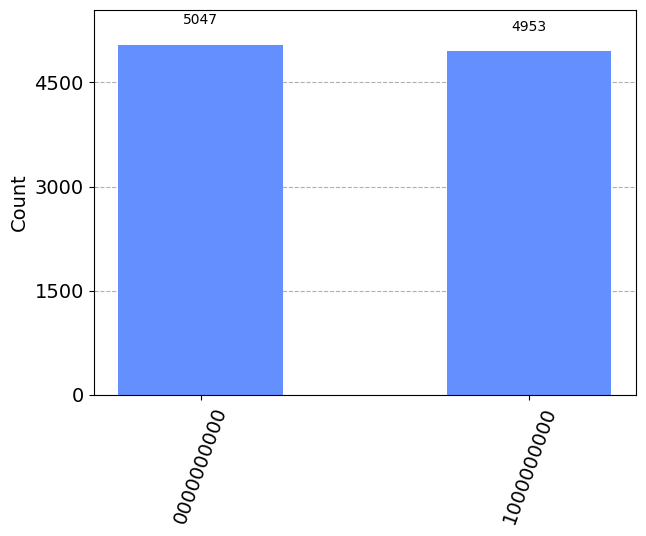

In [100]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=10000).result().get_counts(qc)
plot_histogram(counts)

In [101]:
classical_shor(N, a, counts)

Найденный порядок: 2
Множители числа 21 (а = 13): 3 * 7


(3, 7)

N=35

In [82]:
a = 13
N = 35
n = 6
N_COUNT = n*2
qc = qiskit.QuantumCircuit(4*n+2,N_COUNT) 
for h in range(N_COUNT):
    qc.h(h)
qc.x(N_COUNT)
for control in range(N_COUNT):
    qc.append(U_a_gate(n,dezToBin(modular_exponentiation(a, 2**control, N),n+1),dezToBin(N,n+1)),[control] + list(range(N_COUNT,4*n+2)))
qc.barrier()
myQFT(qc,list(reversed(range(0,N_COUNT))),inverse = True,swaps = True)
qc.barrier()
qc.measure(range(N_COUNT),range(N_COUNT))
qc.draw()

┌───┐┌────────┐                                                       »
 q_0: ┤ H ├┤0       ├───────────────────────────────────────────────────────»
      ├───┤│        │┌────────┐                                             »
 q_1: ┤ H ├┤        ├┤0       ├─────────────────────────────────────────────»
      ├───┤│        ││        │┌───────┐                                    »
 q_2: ┤ H ├┤        ├┤        ├┤0      ├────────────────────────────────────»
      ├───┤│        ││        ││       │┌───────┐                           »
 q_3: ┤ H ├┤        ├┤        ├┤       ├┤0      ├───────────────────────────»
      ├───┤│        ││        ││       ││       │┌───────┐                  »
 q_4: ┤ H ├┤        ├┤        ├┤       ├┤       ├┤0      ├──────────────────»
      ├───┤│        ││        ││       ││       ││       │┌───────┐         »
 q_5: ┤ H ├┤        ├┤        ├┤       ├┤       ├┤       ├┤0      ├─────────»
      ├───┤│        ││        ││       ││       ││       ││       │┌───────┐»
 q_6: ┤ H ├┤        ├┤        ├┤       ├┤       ├┤       ├┤       ├┤0      ├»
      ├───┤│        ││        ││       ││       ││       ││       ││       │»
 q_7: ┤ H ├┤        ├┤        ├┤       ├┤       ├┤       ├┤       ├┤       ├»
      ├───┤│        ││        ││       ││       ││       ││       ││       │»
 q_8: ┤ H ├┤        ├┤        ├┤       ├┤       ├┤       ├┤       ├┤       ├»
      ├───┤│        ││        ││       ││       ││       ││       ││       │»
 q_9: ┤ H ├┤        ├┤        ├┤       ├┤       ├┤       ├┤       ├┤       ├»
      ├───┤│        ││        ││       ││       ││       ││       ││       │»
q_10: ┤ H ├┤        ├┤        ├┤       ├┤       ├┤       ├┤       ├┤       ├»
      ├───┤│        ││        ││       ││       ││       ││       ││       │»
q_11: ┤ H ├┤        ├┤        ├┤       ├┤       ├┤       ├┤       ├┤       ├»
      ├───┤│        ││        ││       ││       ││       ││       ││       │»
q_12: ┤ X ├┤1       ├┤1       ├┤1      ├┤1      ├┤1      ├┤1      ├┤1      ├»
      └───┘│   U_13 ││        ││       ││       ││       ││       ││       │»
q_13: ─────┤2       ├┤2  U_29 ├┤2      ├┤2      ├┤2      ├┤2      ├┤2      ├»
           │        ││        ││   U_1 ││       ││       ││       ││       │»
q_14: ─────┤3       ├┤3       ├┤3      ├┤3  U_1 ├┤3      ├┤3      ├┤3      ├»
           │        ││        ││       ││       ││   U_1 ││       ││       │»
q_15: ─────┤4       ├┤4       ├┤4      ├┤4      ├┤4      ├┤4  U_1 ├┤4      ├»
           │        ││        ││       ││       ││       ││       ││   U_1 │»
q_16: ─────┤5       ├┤5       ├┤5      ├┤5      ├┤5      ├┤5      ├┤5      ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_17: ─────┤6       ├┤6       ├┤6      ├┤6      ├┤6      ├┤6      ├┤6      ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_18: ─────┤7       ├┤7       ├┤7      ├┤7      ├┤7      ├┤7      ├┤7      ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_19: ─────┤8       ├┤8       ├┤8      ├┤8      ├┤8      ├┤8      ├┤8      ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_20: ─────┤9       ├┤9       ├┤9      ├┤9      ├┤9      ├┤9      ├┤9      ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_21: ─────┤10      ├┤10      ├┤10     ├┤10     ├┤10     ├┤10     ├┤10     ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_22: ─────┤11      ├┤11      ├┤11     ├┤11     ├┤11     ├┤11     ├┤11     ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_23: ─────┤12      ├┤12      ├┤12     ├┤12     ├┤12     ├┤12     ├┤12     ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_24: ─────┤13      ├┤13      ├┤13     ├┤13     ├┤13     ├┤13     ├┤13     ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_25: ─────┤14      ├┤14    

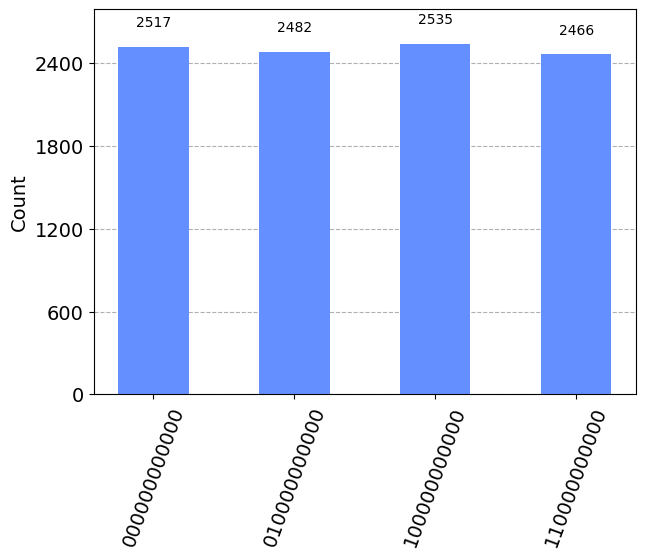

In [75]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=10000).result().get_counts(qc)
plot_histogram(counts)

In [102]:
a = 13
N = 35
n = 6
N_COUNT = n*2
qc = qiskit.QuantumCircuit(4*n+2,N_COUNT) 
for h in range(N_COUNT):
    qc.h(h)
qc.x(N_COUNT)
for control in range(N_COUNT):
    qc.append(U_a_gate(n,dezToBin(modular_exponentiation(a, 2**control, N),n+1),dezToBin(N,n+1)),[control] + list(range(N_COUNT,4*n+2)))
qc.barrier()
myQFT(qc,list(reversed(range(0,N_COUNT))),inverse = True,swaps = True)
qc.barrier()
qc.measure(range(N_COUNT),range(N_COUNT))
qc.draw()

┌───┐┌────────┐                                                       »
 q_0: ┤ H ├┤0       ├───────────────────────────────────────────────────────»
      ├───┤│        │┌────────┐                                             »
 q_1: ┤ H ├┤        ├┤0       ├─────────────────────────────────────────────»
      ├───┤│        ││        │┌───────┐                                    »
 q_2: ┤ H ├┤        ├┤        ├┤0      ├────────────────────────────────────»
      ├───┤│        ││        ││       │┌───────┐                           »
 q_3: ┤ H ├┤        ├┤        ├┤       ├┤0      ├───────────────────────────»
      ├───┤│        ││        ││       ││       │┌───────┐                  »
 q_4: ┤ H ├┤        ├┤        ├┤       ├┤       ├┤0      ├──────────────────»
      ├───┤│        ││        ││       ││       ││       │┌───────┐         »
 q_5: ┤ H ├┤        ├┤        ├┤       ├┤       ├┤       ├┤0      ├─────────»
      ├───┤│        ││        ││       ││       ││       ││       │┌───────┐»
 q_6: ┤ H ├┤        ├┤        ├┤       ├┤       ├┤       ├┤       ├┤0      ├»
      ├───┤│        ││        ││       ││       ││       ││       ││       │»
 q_7: ┤ H ├┤        ├┤        ├┤       ├┤       ├┤       ├┤       ├┤       ├»
      ├───┤│        ││        ││       ││       ││       ││       ││       │»
 q_8: ┤ H ├┤        ├┤        ├┤       ├┤       ├┤       ├┤       ├┤       ├»
      ├───┤│        ││        ││       ││       ││       ││       ││       │»
 q_9: ┤ H ├┤        ├┤        ├┤       ├┤       ├┤       ├┤       ├┤       ├»
      ├───┤│        ││        ││       ││       ││       ││       ││       │»
q_10: ┤ H ├┤        ├┤        ├┤       ├┤       ├┤       ├┤       ├┤       ├»
      ├───┤│        ││        ││       ││       ││       ││       ││       │»
q_11: ┤ H ├┤        ├┤        ├┤       ├┤       ├┤       ├┤       ├┤       ├»
      ├───┤│        ││        ││       ││       ││       ││       ││       │»
q_12: ┤ X ├┤1       ├┤1       ├┤1      ├┤1      ├┤1      ├┤1      ├┤1      ├»
      └───┘│   U_13 ││        ││       ││       ││       ││       ││       │»
q_13: ─────┤2       ├┤2  U_29 ├┤2      ├┤2      ├┤2      ├┤2      ├┤2      ├»
           │        ││        ││   U_1 ││       ││       ││       ││       │»
q_14: ─────┤3       ├┤3       ├┤3      ├┤3  U_1 ├┤3      ├┤3      ├┤3      ├»
           │        ││        ││       ││       ││   U_1 ││       ││       │»
q_15: ─────┤4       ├┤4       ├┤4      ├┤4      ├┤4      ├┤4  U_1 ├┤4      ├»
           │        ││        ││       ││       ││       ││       ││   U_1 │»
q_16: ─────┤5       ├┤5       ├┤5      ├┤5      ├┤5      ├┤5      ├┤5      ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_17: ─────┤6       ├┤6       ├┤6      ├┤6      ├┤6      ├┤6      ├┤6      ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_18: ─────┤7       ├┤7       ├┤7      ├┤7      ├┤7      ├┤7      ├┤7      ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_19: ─────┤8       ├┤8       ├┤8      ├┤8      ├┤8      ├┤8      ├┤8      ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_20: ─────┤9       ├┤9       ├┤9      ├┤9      ├┤9      ├┤9      ├┤9      ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_21: ─────┤10      ├┤10      ├┤10     ├┤10     ├┤10     ├┤10     ├┤10     ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_22: ─────┤11      ├┤11      ├┤11     ├┤11     ├┤11     ├┤11     ├┤11     ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_23: ─────┤12      ├┤12      ├┤12     ├┤12     ├┤12     ├┤12     ├┤12     ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_24: ─────┤13      ├┤13      ├┤13     ├┤13     ├┤13     ├┤13     ├┤13     ├»
           │        ││        ││       ││       ││       ││       ││       │»
q_25: ─────┤14      ├┤14    

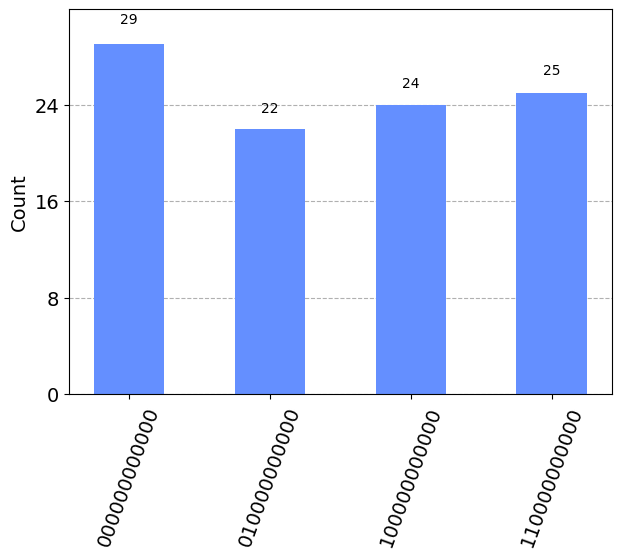

In [103]:
simulator = qiskit.Aer.get_backend('aer_simulator')
counts = qiskit.execute(qc, backend=simulator, shots=100).result().get_counts(qc)
plot_histogram(counts)

In [104]:
classical_shor(N, a, counts)

Найденный порядок: 4
Множители числа 35 (а = 13): 7 * 5


(7, 5)

In [49]:
def Shor(a: int, N: int,n: int,number_shots: int = 10000, backend: str = 'aer_simulator'):
    N_COUNT = n*2
    qc = qiskit.QuantumCircuit(4*n+2,N_COUNT) # 4*n+2 size for complete input bits, 2*n (N_COUNT) size of the control qubits which will also be measured
    for h in range(N_COUNT):
        qc.h(h)
    qc.x(N_COUNT)
    for control in range(N_COUNT):
        qc.append(U_a_gate(n,dezToBin(modular_exponentiation(a, 2**control, N),n+1),dezToBin(N,n+1)),[control] + list(range(N_COUNT,4*n+2)))
    myQFT(qc,list(reversed(range(0,N_COUNT))),inverse = True,swaps = True)
    qc.measure(range(N_COUNT),range(N_COUNT))
    simulator = qiskit.Aer.get_backend(backend)
    sim_result = qiskit.execute(qc, backend=simulator, shots=number_shots).result()
    return sim_result.get_counts(qc)

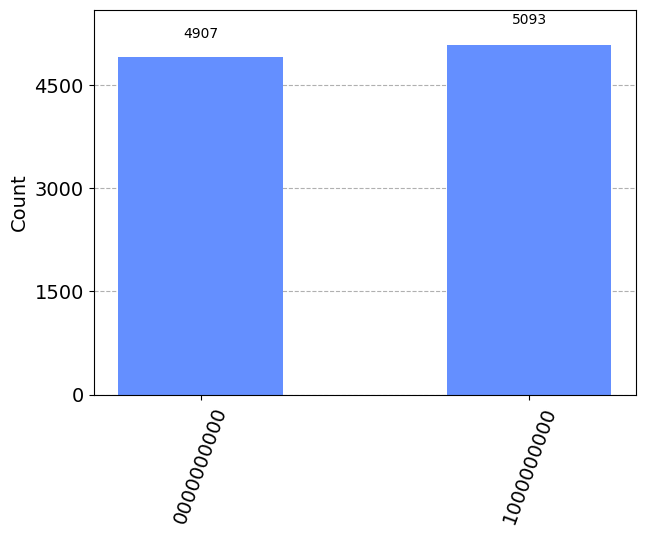

In [26]:
plot_histogram(Shor(13, 21, 5))

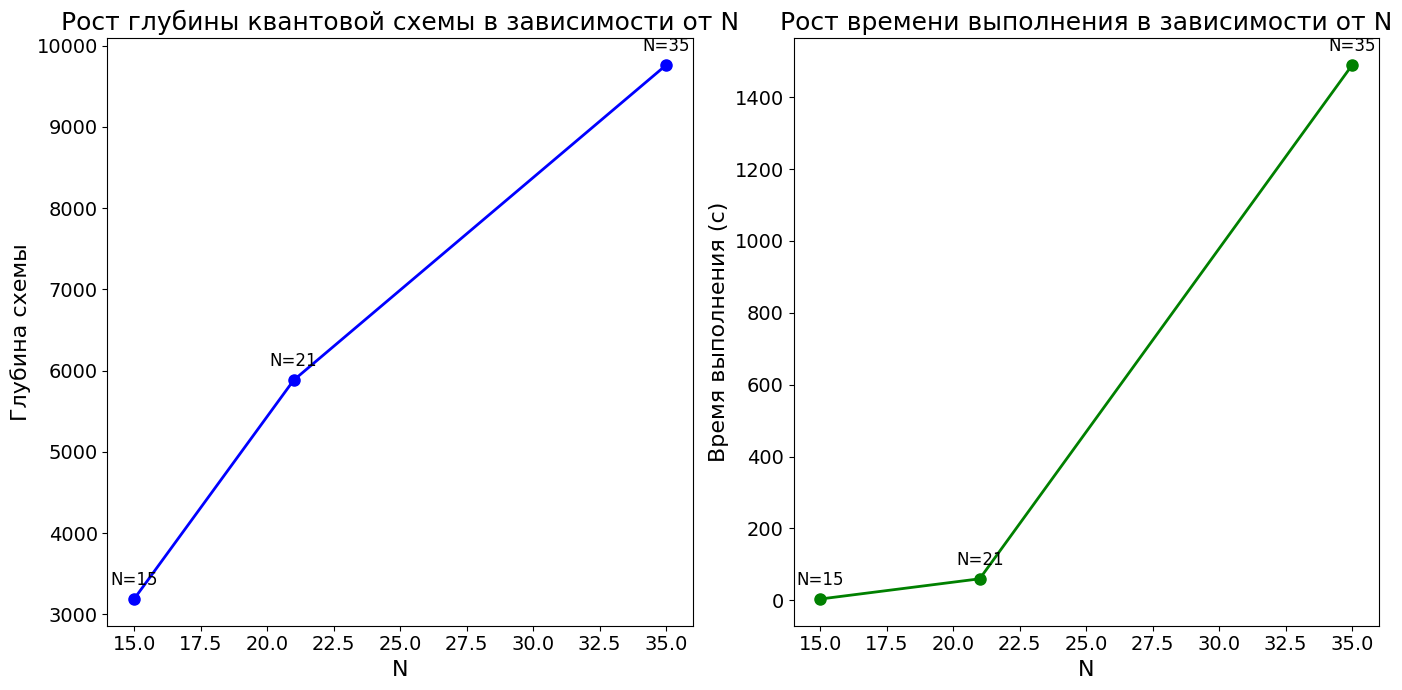

In [142]:
import matplotlib.pyplot as plt
import json

# Загружаем результаты
filenames = ['results_N_15.json', 'results_N_21.json', 'results_N_35.json']
results = []

for filename in filenames:
    with open(filename, 'r') as f:
        data = json.load(f)
        results.append(data)

# Визуализируем результаты
Ns = [result['N'] for result in results]
depths = [result['depth'] for result in results]
execution_times = [result['execution_time'] for result in results]

plt.figure(figsize=(14, 7))

# График глубины квантовой схемы
plt.subplot(1, 2, 1)
plt.plot(Ns, depths, marker='o', linestyle='-', color='blue', linewidth=2, markersize=8)
for i, txt in enumerate(Ns):
    plt.annotate(f'N={txt}', (Ns[i], depths[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)
plt.xlabel('N', fontsize=16)
plt.ylabel('Глубина схемы', fontsize=16)
plt.title('Рост глубины квантовой схемы в зависимости от N', fontsize=18)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)

# График времени выполнения
plt.subplot(1, 2, 2)
plt.plot(Ns, execution_times, marker='o', linestyle='-', color='green', linewidth=2, markersize=8)
for i, txt in enumerate(Ns):
    plt.annotate(f'N={txt}', (Ns[i], execution_times[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)
plt.xlabel('N', fontsize=16)
plt.ylabel('Время выполнения (с)', fontsize=16)
plt.title('Рост времени выполнения в зависимости от N', fontsize=18)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show()

In [ ]:
#для сбора данных, что представлены выше
from fractions import Fraction
from math import gcd

def bitstring_to_int(bitstring):
    """Convert a bitstring to an integer."""
    return int(bitstring, 2)

def continued_fraction_convergents(x):
    """Generate the convergents of a continued fraction."""
    fractions = []
    while x.denominator != 1:
        fractions.append(x)
        x = 1 / (x - int(x))
        x = x.limit_denominator()
    return fractions

def classical_shor(N, a, counts):
    """
    Реализует классическую часть алгоритма Шора на основе результатов квантовой части.

    Parameters:
        N (int): Число, подлежащее факторизации.
        a (int): Основа.
        counts (dict): Полученные измерения квантовой части в виде гистограммы (битовые строки).

    Returns:
        factors (tuple or None): Пара множителей числа N или None, если факторизация не удалась.
    """
    # Преобразуем ключи гистограммы в целые числа
    counts_int = {bitstring_to_int(key): value for key, value in counts.items()}

    # Получение значений с наибольшей частотой
    ordered_counts = sorted(counts_int.items(), key=lambda item: item[1], reverse=True)

    s_values = [k for k, _ in ordered_counts if k != 0]
    n = max(s_values).bit_length()
    M = 2 ** n

    # Найдем r используя аппроксимации непрерывными дробями
    for s in s_values:
        frac = Fraction(s, M).limit_denominator(N)
        convergents = continued_fraction_convergents(frac)
        for convergent in convergents:
            r = convergent.denominator
            if pow(a, r, N) == 1:
                print(f"Найденный порядок: {r}")
                if r % 2 != 0:
                    continue
                factor1 = gcd(pow(a, r // 2, N) - 1, N)
                factor2 = gcd(pow(a, r // 2, N) + 1, N)
                if factor1 != 1 and factor2 != 1 and factor1 * factor2 == N:
                    print(f"Множители числа {N} (а = {a}): {factor1} * {factor2}")
                    return factor1, factor2

    print(f"Не удалось найти множители для числа {N} с основой {a} на основе предоставленных данных.")
    return None  # Если факторизация не удалась
